### Drive mount and package import

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# data 경로 설정 
# root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "alpaco", "Team_1. CODEnter [ Save Form : Name_FileName_Date ]", "1. MAIN", "Reference_file")
root= '/content/drive/MyDrive/Colab Notebooks/alpaco/Team_1. CODEnter [ Save Form : Name_FileName_Date ]/1. MAIN/Reference_file/scratch_small/'

### Dataset 준비


In [ ]:
class SOCAR_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")  ### convert() : 이미지에서 사용하는 컬러 모드 설정 함수 [ RGB , CMYK, HEX ...]
        mask = Image.open(mask_path)

        mask = np.array(mask)[:,:,0]      # 3차원으로 구성된 mask 를 label 로 쓰기 위해 변환

        mask[mask > 0] = 1      ### 0 : 0 값을 1로 모두 변환

        # there is only one class
        mask = torch.as_tensor(mask, dtype=torch.uint8)    
        ### as_tensor : as type같은 느낌 ( 타입 변환  >> tensor 타입으로 )
        ### tensor type은 3차원 이상에서 사용한다고 보면 됨

        target = {}
        target["masks"] = mask
        # target["image_id"] = image_id


        if self.transforms is not None:    
            ### self : class 안에서만 사용된다는 의미 / transform = None 으로 설정되어있음
            ### 만약 transform이 None 값이 아니라면 if문 실행  
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)   ### 이미지 갯수 리턴

### Transforms

In [ ]:
### 이미지 전처리 진행 

class RandomHorizontalFlip(object):     ### 학습률을 높이기 위해 이미지 데이터 셋에 ( argumentation; 증식 ) 노이즈 추가 
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:   ### prob >> 0.5( 50% 이하 ) 값을 넣는 것을 추천 ; 50% 이하일 경우에만 랜덤으로 증식진행 
            height, width = image.shape[-2:]   ### 코드 실행할때 알아서 확인해보세요. ( image.shape )
            image = image.flip(-1)               ### 코드 실행할때 알아서 확인해보세요. ( image.shape )
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target


class ToTensor(object):     ### Tensor 형식으로 변환 함수 ( 기존에는 numpy 형식으로 되어있다.)
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target        

class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, target):
        image = transforms.Resize(self.size)(image)
        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
            ### 스퀴즈(Squeeze) - 1인 차원을 제거한다.
            ### 언스퀴즈(Unsqueeze) - 특정 위치에 1인 차원을 추가한다.
            ### EX) x = x.unsqueeze(dim=1) #[3, 20, 128] -> [3, 1, 20, 128]
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        ### transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]) ; std 표준편차
        return image, target

class Compose(object):       ### object 상속 : python 3에서는 없어도 무방 ( python 2와의 호환성때문에 남겨두는 경우가 있음)
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
def get_transform(train):   ### 훈련 준비 
    transforms = [ToTensor(), Resize((300,300)), Normalize()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        ### 이미지 전처리는 가볍게 랜덤 좌우 뒤집기를 추가해본다. (0.5 확률로)
    return Compose(transforms)

### Model


In [ ]:
deeplabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
deeplabv3.eval()
deeplabv3

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [11]:
deeplabv3.classifier[4]

Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

In [12]:
deeplabv3.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1,1), stride=(1,1))
deeplabv3.classifier[4]

Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
deeplabv3_2class = deeplabv3
torch.save(deeplabv3_2class, '/content/drive/MyDrive/Colab Notebooks/model/2deeplabv3.pth')

### Dataset split, DataLoader

In [13]:
dent_train = SOCAR_Dataset(root + 'train', get_transform(train=True))
dent_valid = SOCAR_Dataset(root + 'valid', get_transform(train=True))
dent_test = SOCAR_Dataset(root + 'test', get_transform(train=False))

train_loader = DataLoader(dent_train, batch_size=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(dent_valid, batch_size=2, shuffle=True, drop_last=True)
test_loader = DataLoader(dent_test, batch_size=2, shuffle=False, drop_last=True)


### Trainer class 정의

In [ ]:
## Trainer class 정의

class Semantic_Seg_Trainer(nn.Module):
    def __init__(self, model,opt="adam", num_class=2, lr=0.001, has_scheduler=False, device="cpu", log_dir="logs", max_epoch=10):
        """
          Args:
            model: 사용할 model
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
        """
        super().__init__()
        
        self.max_epoch = max_epoch
        self.model = model                            
        self.loss = nn.CrossEntropyLoss()             # loss function 정의
        self.num_class = num_class

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device
        
        self.log_dir = log_dir
        if not os.path.exists(log_dir): os.makedirs(log_dir)

    def _get_optimizer(self, opt, lr=0.001): ### lr : learning rate = 0.001(* default 값)
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":    ### sgd : 경사하강법
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        elif opt == "momentum":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.9)
        elif opt == "adamw":
            self.optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, maximize=False)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")    ### 에러 발생시키는 코드

    def _get_scheduler(self):    ### lr를 임의로 변경하려고 사용 (?)
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)
        
        ### step_size == lr
        ### 일정한 스텝마다 감마를 곱해주는 방식 (step_size=5, gamma=0.5)
        ### https://gaussian37.github.io/dl-pytorch-lr_scheduler/   ----   참고


    def train(self, train_loader, valid_loader, max_epochs=10, disp_epochs=1, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": [], "train_miou": [], "valid_miou": []}
        
        for e in range(max_epochs):
            print(f"Start Train Epoch {e}")
            train_loss, train_miou = self._train_epoch(train_loader)
            print(f"Start Valid Epoch {e}")
            valid_loss, valid_miou = self._valid_epoch(valid_loader)
            
            
            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #
            
            history["train_miou"].append(train_miou)      # 
            history["valid_miou"].append(valid_miou)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()

            if e % disp_epochs == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, train miou: {train_miou:>6f}, valid miou: {valid_miou:>6f}, time: {time.time()-start_time:>3f}")
                
                start_time = time.time()   

            self.plot_history(history, save_name=f"{self.log_dir}/log_epoch_{e}.png")       # 그래프 출력
            
            
            model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
            if not os.path.exists(model_dir): os.makedirs(model_dir)    
            torch.save(self.model.state_dict(), os.path.join(model_dir, f"{self.log_dir}/log_epoch_{e:02}.pth"))

### ----------- IOU 계산  https://gaussian37.github.io/vision-segmentation-miou/ --------------- 참고

    def _train_epoch(self, train_loader, disp_step=10):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])               ### numpy : zeros (0으로 채워진 array 생성)
        
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        for (x, y) in train_loader:        # x: data, y:label
            cnt += 1

            x = x.to(self.device)           ### 파이토치 코드 ( 구글링 해보셈 )
            label = y['masks'].to(self.device).type(torch.long)
            
            out = self.model(x)              # model이 예측한 output
            loss = self.loss(out['out'], label)       

            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    
            
            out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)           # meanIoU 계산을 위한 데이터 변형
            out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)               #
            
            ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long)) # ious[0]:background IoU
            ious[1] += self.batch_segmentation_iou(out_target, label)                                         # ious[1]:파손 IoU
            
            if cnt % disp_step == 0:
                iou_back = ious[0]/(cnt*x.shape[0])
                iou_scratch = ious[1]/(cnt*x.shape[0])
                miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                
                print(f"Iter: {cnt}/{len(train_loader)}, train epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                start_time = time.time()   

        epoch_loss /= len(train_loader)  
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Train loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou
  
    def _valid_epoch(self, valid_loader, disp_step=10):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)
                      
                epoch_loss += loss.to("cpu").item()
                
                out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                    

                
                
                if cnt % disp_step == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, valid epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()   

        epoch_loss /= len(valid_loader)
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Valid loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou

    def plot_history(self, history, save_name=None):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss","valid_loss",  }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(16, 8))
        
        
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["train_loss"], color="red", label="train loss")
        ax.plot(history["valid_loss"], color="blue", label="valid loss")
        ax.title.set_text("Loss")
        ax.legend()
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["train_miou"], color="red", label="train miou")
        ax.plot(history["valid_miou"], color="blue", label="valid miou")
        ax.title.set_text("miou")
        ax.legend()

        plt.show()
                      
        if not save_name == None:     # graph 저장
            plt.savefig(save_name)
                      
        

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()
                      
                out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                
                if cnt % 10 == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, test epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()  

        epoch_loss /= len(test_loader)
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        
        print(f"Test loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

    
    def batch_segmentation_iou(self, outputs, labels):
        """
            outputs, labels : (batch, h, w)
        """
        
        SMOOTH = 1e-6

        intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
        union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

        iou = (intersection + SMOOTH) / (union + SMOOTH)
        
        
        return torch.sum(iou).to("cpu").numpy()

      ### Fine-tuning
device 를 gpu 로 설정하고 trainer를 정의해봅시다.
정의된 trainer 와 train, valid 데이터로 모델을 학습을 시켜봅시다

In [ ]:
device = "cuda"
trainer = Semantic_Seg_Trainer(model=deeplabv3, opt="adamw", lr=0.0001, has_scheduler=True, device=device).to(device)

Adjusting learning rate of group 0 to 1.0000e-04.


===== Train Start =====
Start Train Epoch 0
Iter: 10/100, train epcoh loss: 0.835059, miou: 0.062476, iou_back : 0.102021, iou_scratch : 0.022930, time: 11.856949
Iter: 20/100, train epcoh loss: 0.788088, miou: 0.121084, iou_back : 0.210337, iou_scratch : 0.031832, time: 11.249109
Iter: 30/100, train epcoh loss: 0.743222, miou: 0.209623, iou_back : 0.367346, iou_scratch : 0.051900, time: 10.757181
Iter: 40/100, train epcoh loss: 0.701385, miou: 0.272533, iou_back : 0.481109, iou_scratch : 0.063957, time: 10.514165
Iter: 50/100, train epcoh loss: 0.660225, miou: 0.323181, iou_back : 0.569261, iou_scratch : 0.077102, time: 11.170538
Iter: 60/100, train epcoh loss: 0.623315, miou: 0.357610, iou_back : 0.626876, iou_scratch : 0.088344, time: 10.663655
Iter: 70/100, train epcoh loss: 0.588929, miou: 0.385596, iou_back : 0.672872, iou_scratch : 0.098320, time: 9.535219
Iter: 80/100, train epcoh loss: 0.557840, miou: 0.407285, iou_back : 0.708288, iou_scratch : 0.106282, time: 9.935445
Iter: 

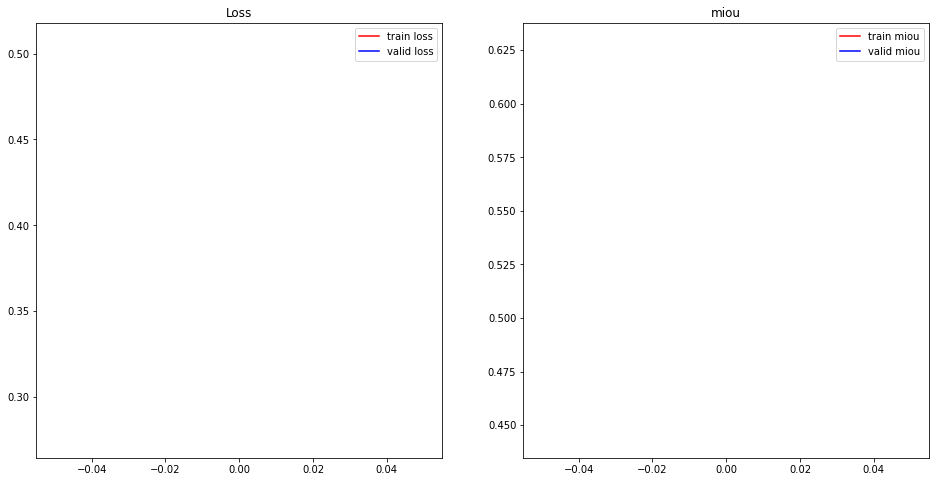

Start Train Epoch 1
Iter: 10/100, train epcoh loss: 0.270672, miou: 0.592286, iou_back : 0.962430, iou_scratch : 0.222142, time: 4.219845
Iter: 20/100, train epcoh loss: 0.261767, miou: 0.588876, iou_back : 0.962534, iou_scratch : 0.215219, time: 3.798024
Iter: 30/100, train epcoh loss: 0.250149, miou: 0.582416, iou_back : 0.966941, iou_scratch : 0.197890, time: 3.860532
Iter: 40/100, train epcoh loss: 0.244161, miou: 0.597059, iou_back : 0.965743, iou_scratch : 0.228374, time: 3.681337
Iter: 50/100, train epcoh loss: 0.241741, miou: 0.586216, iou_back : 0.962929, iou_scratch : 0.209503, time: 3.606302
Iter: 60/100, train epcoh loss: 0.234970, miou: 0.587570, iou_back : 0.964565, iou_scratch : 0.210575, time: 3.782974
Iter: 70/100, train epcoh loss: 0.230304, miou: 0.585863, iou_back : 0.964483, iou_scratch : 0.207244, time: 3.561778
Iter: 80/100, train epcoh loss: 0.224415, miou: 0.586172, iou_back : 0.965303, iou_scratch : 0.207040, time: 3.621544
Iter: 90/100, train epcoh loss: 0.21

<Figure size 432x288 with 0 Axes>

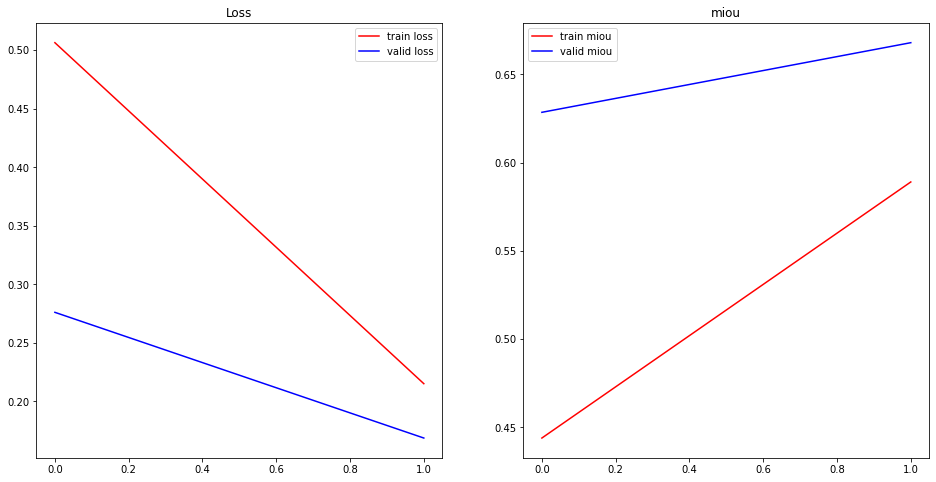

Start Train Epoch 2
Iter: 10/100, train epcoh loss: 0.160005, miou: 0.597835, iou_back : 0.973625, iou_scratch : 0.222045, time: 3.711980
Iter: 20/100, train epcoh loss: 0.158337, miou: 0.611089, iou_back : 0.971248, iou_scratch : 0.250929, time: 3.565972
Iter: 30/100, train epcoh loss: 0.157922, miou: 0.619551, iou_back : 0.969989, iou_scratch : 0.269114, time: 3.679203
Iter: 40/100, train epcoh loss: 0.155615, miou: 0.618401, iou_back : 0.969739, iou_scratch : 0.267062, time: 3.703593
Iter: 50/100, train epcoh loss: 0.153213, miou: 0.616272, iou_back : 0.970833, iou_scratch : 0.261712, time: 3.608194
Iter: 60/100, train epcoh loss: 0.154830, miou: 0.620628, iou_back : 0.968147, iou_scratch : 0.273110, time: 3.590675
Iter: 70/100, train epcoh loss: 0.152869, miou: 0.616288, iou_back : 0.968082, iou_scratch : 0.264494, time: 3.578401
Iter: 80/100, train epcoh loss: 0.151450, miou: 0.614634, iou_back : 0.968262, iou_scratch : 0.261006, time: 3.589793
Iter: 90/100, train epcoh loss: 0.14

<Figure size 432x288 with 0 Axes>

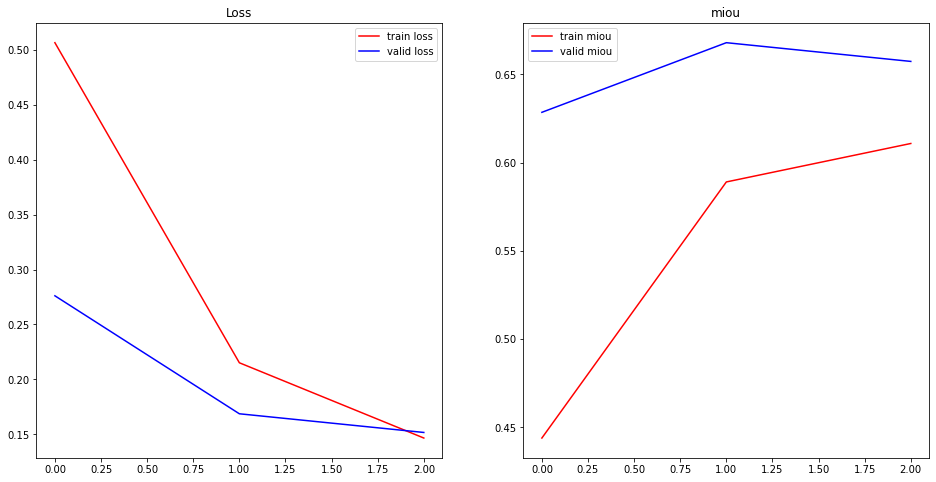

Start Train Epoch 3
Iter: 10/100, train epcoh loss: 0.122098, miou: 0.633214, iou_back : 0.973583, iou_scratch : 0.292845, time: 4.082412
Iter: 20/100, train epcoh loss: 0.120200, miou: 0.614983, iou_back : 0.974453, iou_scratch : 0.255513, time: 3.476763
Iter: 30/100, train epcoh loss: 0.124307, miou: 0.608490, iou_back : 0.970894, iou_scratch : 0.246086, time: 3.825674
Iter: 40/100, train epcoh loss: 0.128241, miou: 0.606393, iou_back : 0.967775, iou_scratch : 0.245012, time: 3.816778
Iter: 50/100, train epcoh loss: 0.124017, miou: 0.618290, iou_back : 0.969888, iou_scratch : 0.266692, time: 3.645486
Iter: 60/100, train epcoh loss: 0.123794, miou: 0.621968, iou_back : 0.970080, iou_scratch : 0.273857, time: 3.566483
Iter: 70/100, train epcoh loss: 0.124524, miou: 0.619631, iou_back : 0.969580, iou_scratch : 0.269682, time: 3.570859
Iter: 80/100, train epcoh loss: 0.125420, miou: 0.610709, iou_back : 0.968952, iou_scratch : 0.252467, time: 3.814191
Iter: 90/100, train epcoh loss: 0.12

<Figure size 432x288 with 0 Axes>

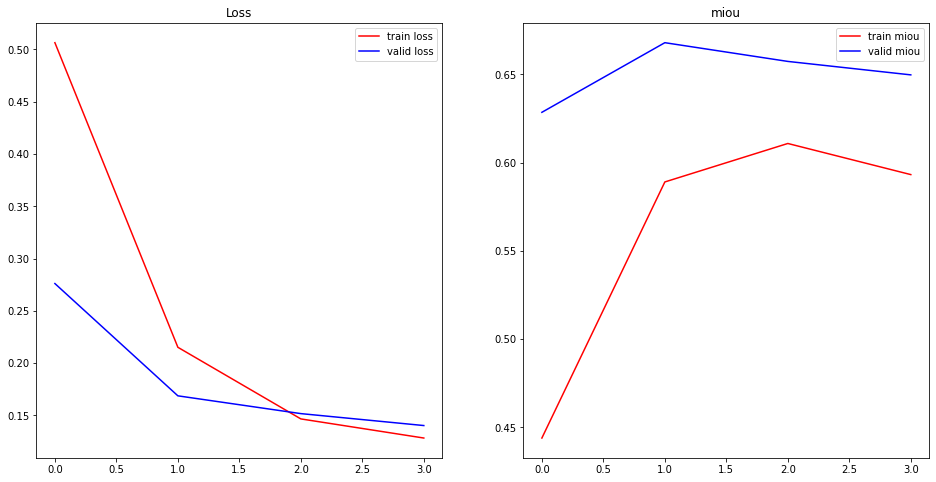

Start Train Epoch 4
Iter: 10/100, train epcoh loss: 0.108135, miou: 0.579475, iou_back : 0.974747, iou_scratch : 0.184203, time: 3.778116
Iter: 20/100, train epcoh loss: 0.109036, miou: 0.568571, iou_back : 0.973272, iou_scratch : 0.163870, time: 3.546137
Iter: 30/100, train epcoh loss: 0.112422, miou: 0.562930, iou_back : 0.972349, iou_scratch : 0.153511, time: 3.736770
Iter: 40/100, train epcoh loss: 0.126416, miou: 0.546570, iou_back : 0.965926, iou_scratch : 0.127214, time: 3.749084
Iter: 50/100, train epcoh loss: 0.125104, miou: 0.547942, iou_back : 0.965919, iou_scratch : 0.129964, time: 3.677561
Iter: 60/100, train epcoh loss: 0.126547, miou: 0.554713, iou_back : 0.964788, iou_scratch : 0.144637, time: 3.572320
Iter: 70/100, train epcoh loss: 0.128452, miou: 0.551604, iou_back : 0.964278, iou_scratch : 0.138930, time: 3.599041
Iter: 80/100, train epcoh loss: 0.126903, miou: 0.552075, iou_back : 0.965130, iou_scratch : 0.139020, time: 3.716824
Iter: 90/100, train epcoh loss: 0.12

<Figure size 432x288 with 0 Axes>

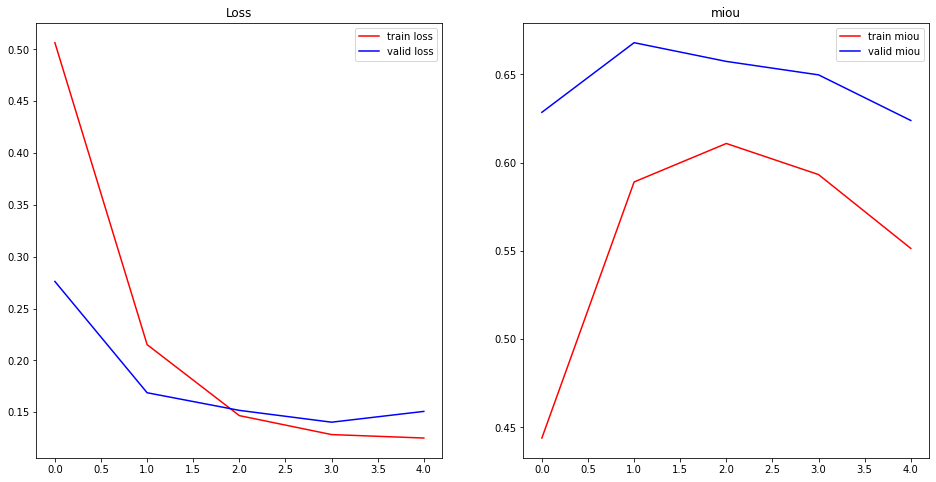

Start Train Epoch 5
Iter: 10/100, train epcoh loss: 0.137784, miou: 0.546016, iou_back : 0.957037, iou_scratch : 0.134996, time: 4.219229
Iter: 20/100, train epcoh loss: 0.126072, miou: 0.559042, iou_back : 0.960416, iou_scratch : 0.157668, time: 3.842416
Iter: 30/100, train epcoh loss: 0.116998, miou: 0.573990, iou_back : 0.964318, iou_scratch : 0.183661, time: 3.705738
Iter: 40/100, train epcoh loss: 0.120822, miou: 0.578140, iou_back : 0.962823, iou_scratch : 0.193457, time: 3.589833
Iter: 50/100, train epcoh loss: 0.114254, miou: 0.574315, iou_back : 0.966271, iou_scratch : 0.182360, time: 3.572925
Iter: 60/100, train epcoh loss: 0.111309, miou: 0.575974, iou_back : 0.968207, iou_scratch : 0.183741, time: 3.548432
Iter: 70/100, train epcoh loss: 0.106923, miou: 0.570137, iou_back : 0.970057, iou_scratch : 0.170217, time: 3.546361
Iter: 80/100, train epcoh loss: 0.108894, miou: 0.567928, iou_back : 0.969008, iou_scratch : 0.166847, time: 3.605937
Iter: 90/100, train epcoh loss: 0.10

<Figure size 432x288 with 0 Axes>

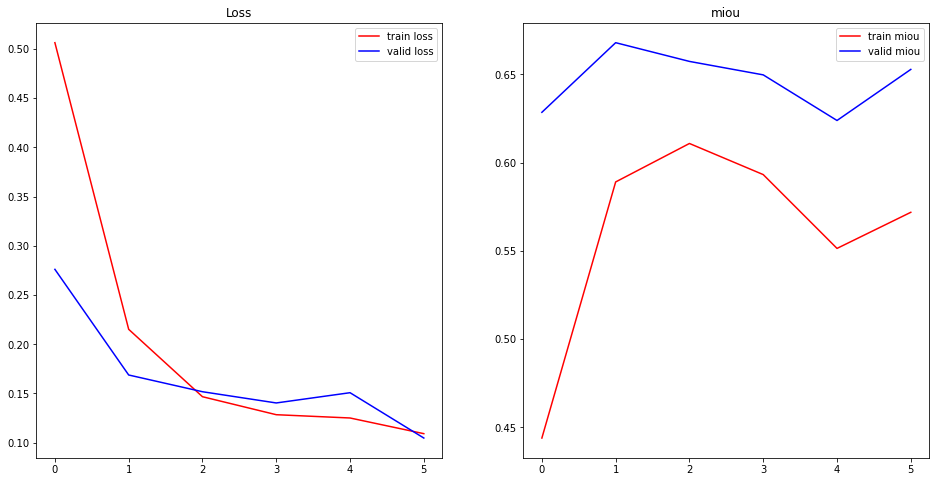

Start Train Epoch 6
Iter: 10/100, train epcoh loss: 0.107925, miou: 0.607516, iou_back : 0.966701, iou_scratch : 0.248331, time: 3.741429
Iter: 20/100, train epcoh loss: 0.103505, miou: 0.576542, iou_back : 0.970328, iou_scratch : 0.182756, time: 3.611900
Iter: 30/100, train epcoh loss: 0.102361, miou: 0.577037, iou_back : 0.969972, iou_scratch : 0.184102, time: 3.727056
Iter: 40/100, train epcoh loss: 0.102008, miou: 0.568433, iou_back : 0.969414, iou_scratch : 0.167453, time: 3.743465
Iter: 50/100, train epcoh loss: 0.099315, miou: 0.570099, iou_back : 0.970774, iou_scratch : 0.169425, time: 3.554337
Iter: 60/100, train epcoh loss: 0.106846, miou: 0.572250, iou_back : 0.967218, iou_scratch : 0.177281, time: 3.621336
Iter: 70/100, train epcoh loss: 0.105637, miou: 0.577931, iou_back : 0.967503, iou_scratch : 0.188360, time: 3.621824
Iter: 80/100, train epcoh loss: 0.106374, miou: 0.581944, iou_back : 0.966925, iou_scratch : 0.196963, time: 3.643106
Iter: 90/100, train epcoh loss: 0.10

<Figure size 432x288 with 0 Axes>

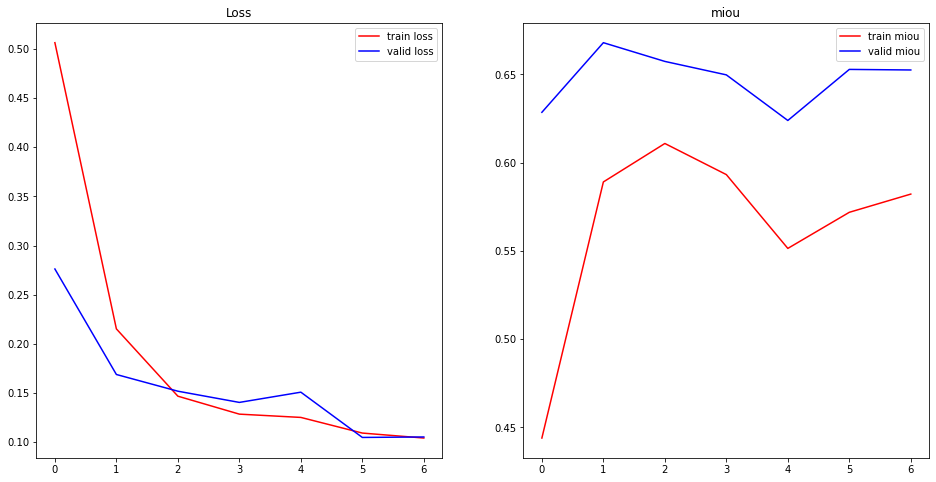

Start Train Epoch 7
Iter: 10/100, train epcoh loss: 0.114955, miou: 0.578908, iou_back : 0.961462, iou_scratch : 0.196354, time: 3.909195
Iter: 20/100, train epcoh loss: 0.109778, miou: 0.578209, iou_back : 0.962038, iou_scratch : 0.194381, time: 3.594162
Iter: 30/100, train epcoh loss: 0.105211, miou: 0.594103, iou_back : 0.965328, iou_scratch : 0.222878, time: 3.704861
Iter: 40/100, train epcoh loss: 0.097239, miou: 0.596963, iou_back : 0.969185, iou_scratch : 0.224740, time: 3.755510
Iter: 50/100, train epcoh loss: 0.092738, miou: 0.592310, iou_back : 0.971402, iou_scratch : 0.213218, time: 3.583817
Iter: 60/100, train epcoh loss: 0.094533, miou: 0.588763, iou_back : 0.970697, iou_scratch : 0.206829, time: 3.577802
Iter: 70/100, train epcoh loss: 0.097491, miou: 0.584846, iou_back : 0.969504, iou_scratch : 0.200187, time: 3.584300
Iter: 80/100, train epcoh loss: 0.097570, miou: 0.588685, iou_back : 0.969413, iou_scratch : 0.207957, time: 3.570274
Iter: 90/100, train epcoh loss: 0.09

<Figure size 432x288 with 0 Axes>

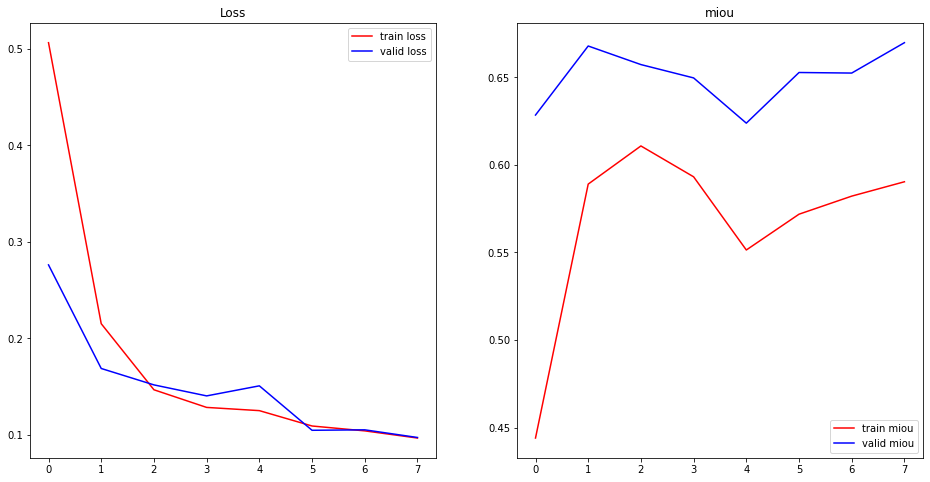

Start Train Epoch 8
Iter: 10/100, train epcoh loss: 0.094890, miou: 0.605143, iou_back : 0.967763, iou_scratch : 0.242523, time: 3.748857
Iter: 20/100, train epcoh loss: 0.106070, miou: 0.606622, iou_back : 0.963682, iou_scratch : 0.249561, time: 3.581146
Iter: 30/100, train epcoh loss: 0.104257, miou: 0.610441, iou_back : 0.964379, iou_scratch : 0.256503, time: 3.659015
Iter: 40/100, train epcoh loss: 0.100774, miou: 0.605267, iou_back : 0.966462, iou_scratch : 0.244073, time: 3.716012
Iter: 50/100, train epcoh loss: 0.098541, miou: 0.607454, iou_back : 0.967694, iou_scratch : 0.247213, time: 3.642428
Iter: 60/100, train epcoh loss: 0.095499, miou: 0.609962, iou_back : 0.969017, iou_scratch : 0.250906, time: 3.605984
Iter: 70/100, train epcoh loss: 0.095904, miou: 0.610884, iou_back : 0.968576, iou_scratch : 0.253192, time: 3.563776
Iter: 80/100, train epcoh loss: 0.093751, miou: 0.607541, iou_back : 0.969347, iou_scratch : 0.245735, time: 3.662352
Iter: 90/100, train epcoh loss: 0.09

<Figure size 432x288 with 0 Axes>

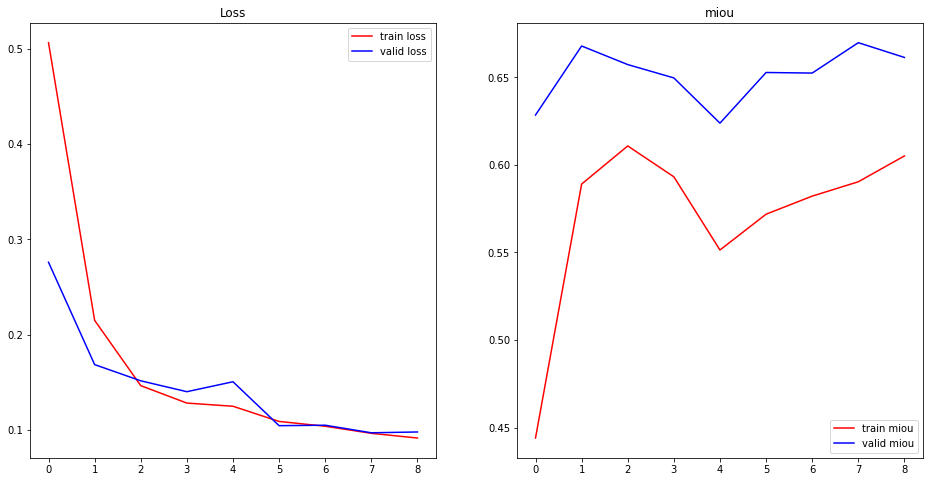

Start Train Epoch 9
Iter: 10/100, train epcoh loss: 0.091276, miou: 0.599586, iou_back : 0.971947, iou_scratch : 0.227224, time: 3.781700
Iter: 20/100, train epcoh loss: 0.090545, miou: 0.607861, iou_back : 0.970482, iou_scratch : 0.245240, time: 3.553801
Iter: 30/100, train epcoh loss: 0.091968, miou: 0.610553, iou_back : 0.970149, iou_scratch : 0.250957, time: 3.704048
Iter: 40/100, train epcoh loss: 0.087865, miou: 0.602561, iou_back : 0.971716, iou_scratch : 0.233405, time: 3.674952
Iter: 50/100, train epcoh loss: 0.087014, miou: 0.601512, iou_back : 0.972170, iou_scratch : 0.230853, time: 3.586730
Iter: 60/100, train epcoh loss: 0.089590, miou: 0.607943, iou_back : 0.971485, iou_scratch : 0.244402, time: 3.593379
Iter: 70/100, train epcoh loss: 0.087075, miou: 0.606239, iou_back : 0.972510, iou_scratch : 0.239968, time: 3.593858
Iter: 80/100, train epcoh loss: 0.086080, miou: 0.608101, iou_back : 0.972888, iou_scratch : 0.243313, time: 3.616029
Iter: 90/100, train epcoh loss: 0.08

<Figure size 432x288 with 0 Axes>

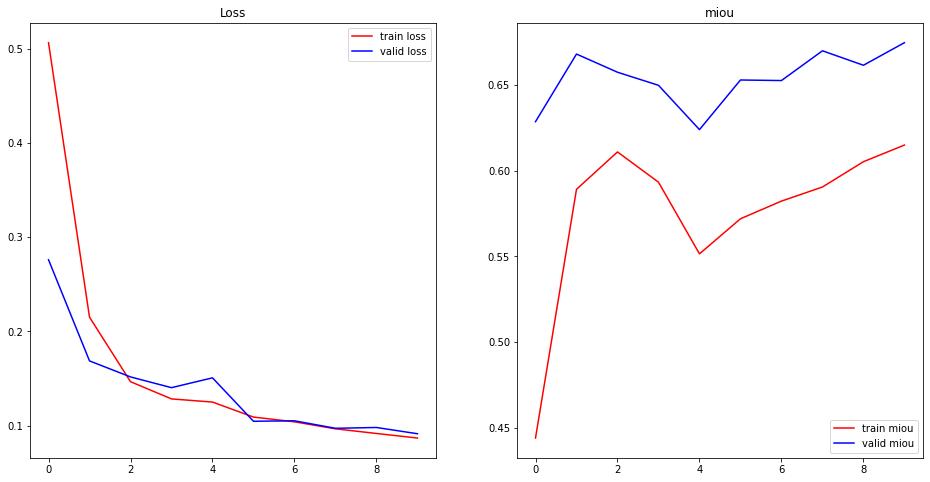

Start Train Epoch 10
Iter: 10/100, train epcoh loss: 0.069664, miou: 0.635185, iou_back : 0.979550, iou_scratch : 0.290820, time: 3.779557
Iter: 20/100, train epcoh loss: 0.086486, miou: 0.624149, iou_back : 0.971271, iou_scratch : 0.277027, time: 3.576654
Iter: 30/100, train epcoh loss: 0.082844, miou: 0.628233, iou_back : 0.972511, iou_scratch : 0.283955, time: 3.742285
Iter: 40/100, train epcoh loss: 0.084016, miou: 0.625351, iou_back : 0.972411, iou_scratch : 0.278291, time: 3.707575
Iter: 50/100, train epcoh loss: 0.082335, miou: 0.620845, iou_back : 0.973160, iou_scratch : 0.268530, time: 3.534997
Iter: 60/100, train epcoh loss: 0.081438, miou: 0.630428, iou_back : 0.973256, iou_scratch : 0.287600, time: 3.574935
Iter: 70/100, train epcoh loss: 0.084207, miou: 0.633051, iou_back : 0.972174, iou_scratch : 0.293929, time: 3.565212
Iter: 80/100, train epcoh loss: 0.085145, miou: 0.631204, iou_back : 0.971632, iou_scratch : 0.290775, time: 3.553195
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

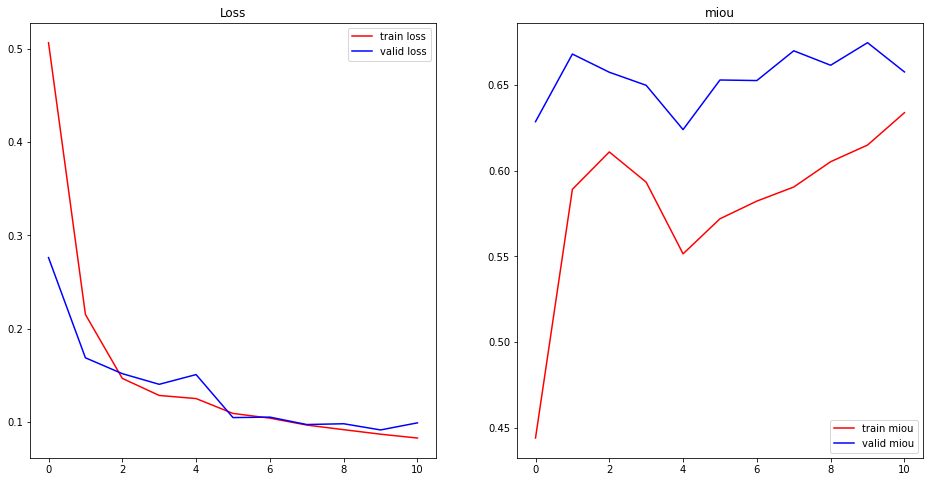

Start Train Epoch 11
Iter: 10/100, train epcoh loss: 0.075264, miou: 0.645632, iou_back : 0.977960, iou_scratch : 0.313305, time: 3.777203
Iter: 20/100, train epcoh loss: 0.068171, miou: 0.622583, iou_back : 0.981919, iou_scratch : 0.263248, time: 3.805080
Iter: 30/100, train epcoh loss: 0.072155, miou: 0.599921, iou_back : 0.979505, iou_scratch : 0.220336, time: 3.589147
Iter: 40/100, train epcoh loss: 0.073950, miou: 0.607524, iou_back : 0.977850, iou_scratch : 0.237197, time: 3.553664
Iter: 50/100, train epcoh loss: 0.073011, miou: 0.615013, iou_back : 0.977751, iou_scratch : 0.252275, time: 3.594601
Iter: 60/100, train epcoh loss: 0.071877, miou: 0.625708, iou_back : 0.978142, iou_scratch : 0.273275, time: 3.535585
Iter: 70/100, train epcoh loss: 0.073130, miou: 0.622220, iou_back : 0.977229, iou_scratch : 0.267210, time: 3.582630
Iter: 80/100, train epcoh loss: 0.074247, miou: 0.627510, iou_back : 0.976718, iou_scratch : 0.278301, time: 3.603471
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

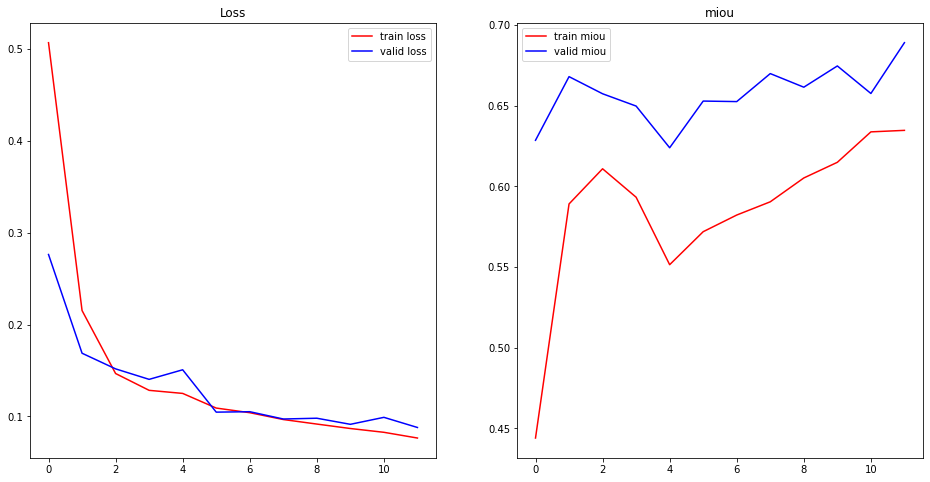

Start Train Epoch 12
Iter: 10/100, train epcoh loss: 0.097589, miou: 0.691119, iou_back : 0.962127, iou_scratch : 0.420111, time: 3.708175
Iter: 20/100, train epcoh loss: 0.084054, miou: 0.689130, iou_back : 0.970254, iou_scratch : 0.408005, time: 3.542361
Iter: 30/100, train epcoh loss: 0.081714, miou: 0.684984, iou_back : 0.971656, iou_scratch : 0.398313, time: 3.684300
Iter: 40/100, train epcoh loss: 0.079249, miou: 0.664358, iou_back : 0.973162, iou_scratch : 0.355554, time: 3.725318
Iter: 50/100, train epcoh loss: 0.078424, miou: 0.661056, iou_back : 0.973558, iou_scratch : 0.348554, time: 3.538030
Iter: 60/100, train epcoh loss: 0.076726, miou: 0.649079, iou_back : 0.974522, iou_scratch : 0.323636, time: 3.609159
Iter: 70/100, train epcoh loss: 0.075100, miou: 0.644812, iou_back : 0.975334, iou_scratch : 0.314291, time: 3.619294
Iter: 80/100, train epcoh loss: 0.075659, miou: 0.645791, iou_back : 0.974945, iou_scratch : 0.316636, time: 3.654017
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

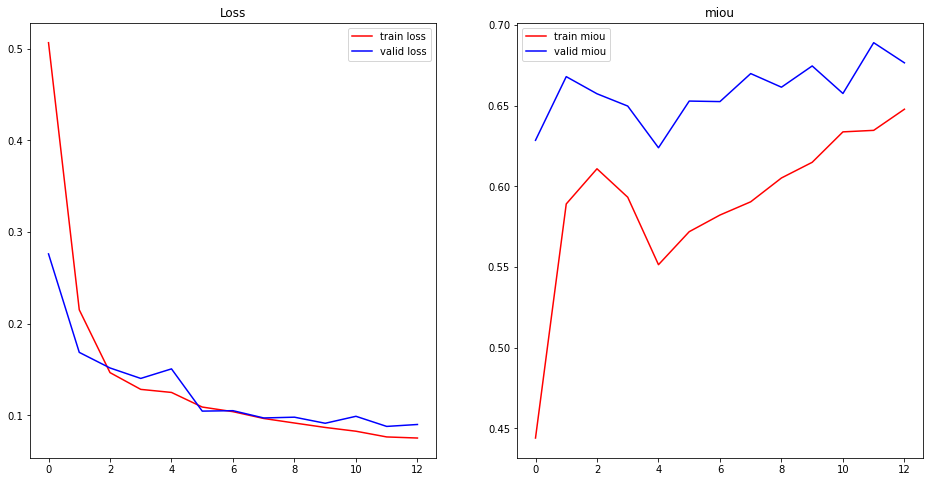

Start Train Epoch 13
Iter: 10/100, train epcoh loss: 0.066636, miou: 0.606962, iou_back : 0.977088, iou_scratch : 0.236837, time: 3.748338
Iter: 20/100, train epcoh loss: 0.074741, miou: 0.652626, iou_back : 0.975216, iou_scratch : 0.330037, time: 3.559540
Iter: 30/100, train epcoh loss: 0.068862, miou: 0.667954, iou_back : 0.977989, iou_scratch : 0.357918, time: 3.730609
Iter: 40/100, train epcoh loss: 0.069976, miou: 0.659180, iou_back : 0.977762, iou_scratch : 0.340599, time: 3.711078
Iter: 50/100, train epcoh loss: 0.068957, miou: 0.654240, iou_back : 0.978245, iou_scratch : 0.330235, time: 3.541996
Iter: 60/100, train epcoh loss: 0.072804, miou: 0.648537, iou_back : 0.976166, iou_scratch : 0.320908, time: 3.598235
Iter: 70/100, train epcoh loss: 0.072536, miou: 0.644845, iou_back : 0.976293, iou_scratch : 0.313397, time: 3.599580
Iter: 80/100, train epcoh loss: 0.072755, miou: 0.645002, iou_back : 0.976138, iou_scratch : 0.313866, time: 3.591529
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

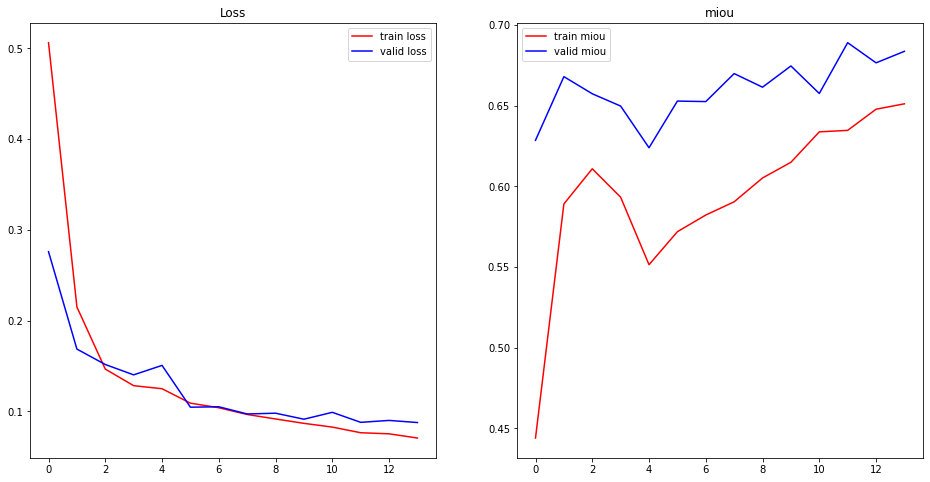

Start Train Epoch 14
Iter: 10/100, train epcoh loss: 0.068042, miou: 0.634609, iou_back : 0.978248, iou_scratch : 0.290970, time: 3.754811
Iter: 20/100, train epcoh loss: 0.066676, miou: 0.633948, iou_back : 0.978968, iou_scratch : 0.288928, time: 3.557525
Iter: 30/100, train epcoh loss: 0.071571, miou: 0.630580, iou_back : 0.975672, iou_scratch : 0.285487, time: 3.752207
Iter: 40/100, train epcoh loss: 0.072813, miou: 0.641690, iou_back : 0.975206, iou_scratch : 0.308174, time: 3.721652
Iter: 50/100, train epcoh loss: 0.070041, miou: 0.640812, iou_back : 0.976616, iou_scratch : 0.305009, time: 3.570401
Iter: 60/100, train epcoh loss: 0.067292, miou: 0.647694, iou_back : 0.978229, iou_scratch : 0.317160, time: 3.563286
Iter: 70/100, train epcoh loss: 0.067836, miou: 0.653188, iou_back : 0.977819, iou_scratch : 0.328558, time: 3.582493
Iter: 80/100, train epcoh loss: 0.067177, miou: 0.657350, iou_back : 0.978138, iou_scratch : 0.336563, time: 3.651169
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

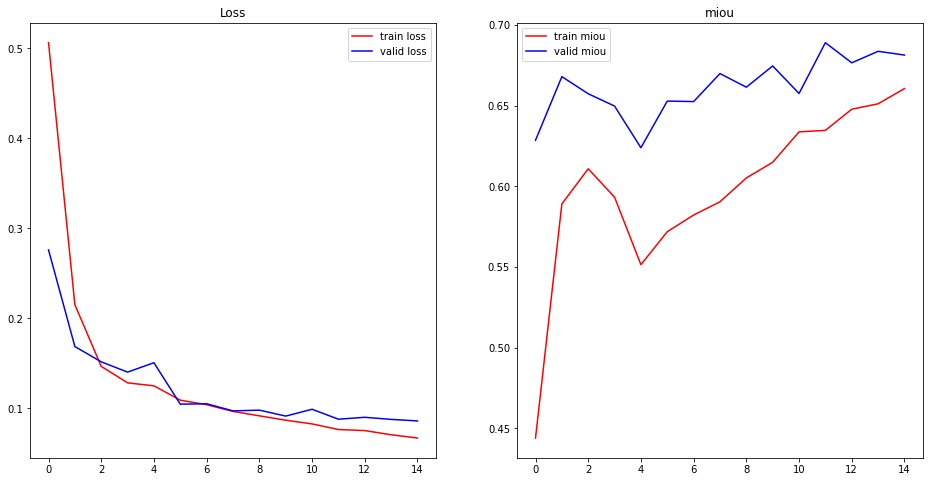

Start Train Epoch 15
Iter: 10/100, train epcoh loss: 0.065554, miou: 0.674206, iou_back : 0.977857, iou_scratch : 0.370555, time: 3.782229
Iter: 20/100, train epcoh loss: 0.059737, miou: 0.667316, iou_back : 0.981365, iou_scratch : 0.353268, time: 3.609949
Iter: 30/100, train epcoh loss: 0.062612, miou: 0.667369, iou_back : 0.979653, iou_scratch : 0.355085, time: 3.673256
Iter: 40/100, train epcoh loss: 0.063482, miou: 0.664331, iou_back : 0.979344, iou_scratch : 0.349318, time: 3.729046
Iter: 50/100, train epcoh loss: 0.061506, miou: 0.666825, iou_back : 0.980198, iou_scratch : 0.353451, time: 3.585680
Iter: 60/100, train epcoh loss: 0.061494, miou: 0.667766, iou_back : 0.980406, iou_scratch : 0.355126, time: 3.614968
Iter: 70/100, train epcoh loss: 0.064777, miou: 0.666632, iou_back : 0.978689, iou_scratch : 0.354574, time: 3.536193
Iter: 80/100, train epcoh loss: 0.064485, miou: 0.665582, iou_back : 0.978948, iou_scratch : 0.352216, time: 3.607658
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

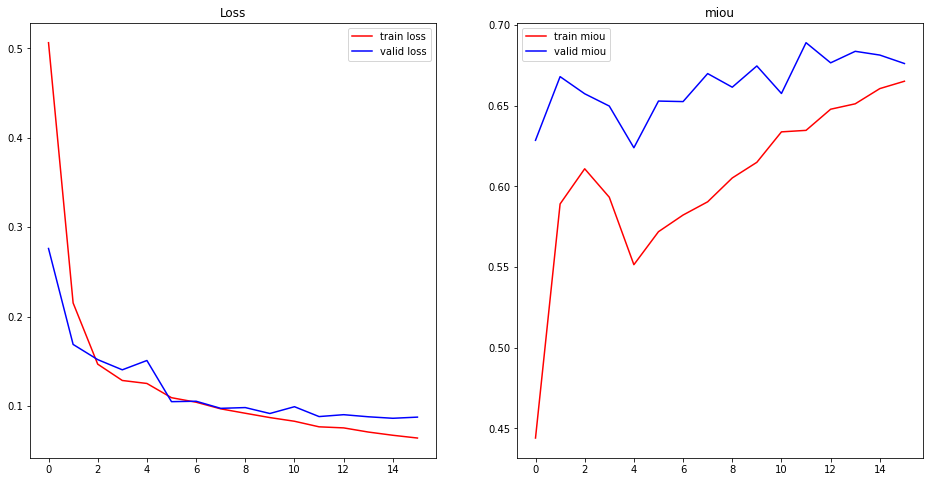

Start Train Epoch 16
Iter: 10/100, train epcoh loss: 0.064772, miou: 0.646330, iou_back : 0.977757, iou_scratch : 0.314903, time: 3.789587
Iter: 20/100, train epcoh loss: 0.057380, miou: 0.686880, iou_back : 0.981857, iou_scratch : 0.391903, time: 3.570565
Iter: 30/100, train epcoh loss: 0.057017, miou: 0.683447, iou_back : 0.981291, iou_scratch : 0.385603, time: 3.687254
Iter: 40/100, train epcoh loss: 0.059879, miou: 0.680264, iou_back : 0.980185, iou_scratch : 0.380343, time: 3.708739
Iter: 50/100, train epcoh loss: 0.059201, miou: 0.685071, iou_back : 0.980642, iou_scratch : 0.389500, time: 3.641424
Iter: 60/100, train epcoh loss: 0.060105, miou: 0.675815, iou_back : 0.980312, iou_scratch : 0.371318, time: 3.571465
Iter: 70/100, train epcoh loss: 0.059876, miou: 0.679298, iou_back : 0.980561, iou_scratch : 0.378035, time: 3.594224
Iter: 80/100, train epcoh loss: 0.061626, miou: 0.676709, iou_back : 0.979694, iou_scratch : 0.373724, time: 3.577146
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

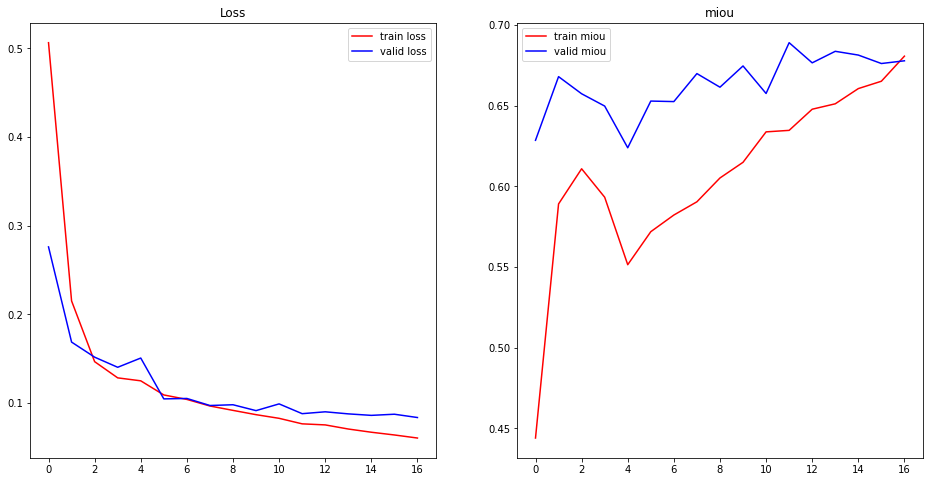

Start Train Epoch 17
Iter: 10/100, train epcoh loss: 0.061690, miou: 0.653238, iou_back : 0.980129, iou_scratch : 0.326347, time: 3.731027
Iter: 20/100, train epcoh loss: 0.061499, miou: 0.653394, iou_back : 0.979498, iou_scratch : 0.327291, time: 3.610487
Iter: 30/100, train epcoh loss: 0.061694, miou: 0.652713, iou_back : 0.979949, iou_scratch : 0.325478, time: 3.873331
Iter: 40/100, train epcoh loss: 0.063394, miou: 0.656209, iou_back : 0.979148, iou_scratch : 0.333269, time: 3.599185
Iter: 50/100, train epcoh loss: 0.059221, miou: 0.656807, iou_back : 0.981201, iou_scratch : 0.332413, time: 3.558737
Iter: 60/100, train epcoh loss: 0.059888, miou: 0.660229, iou_back : 0.980666, iou_scratch : 0.339793, time: 3.638351
Iter: 70/100, train epcoh loss: 0.059403, miou: 0.662707, iou_back : 0.980972, iou_scratch : 0.344441, time: 3.615479
Iter: 80/100, train epcoh loss: 0.059883, miou: 0.668923, iou_back : 0.980565, iou_scratch : 0.357282, time: 3.560439
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

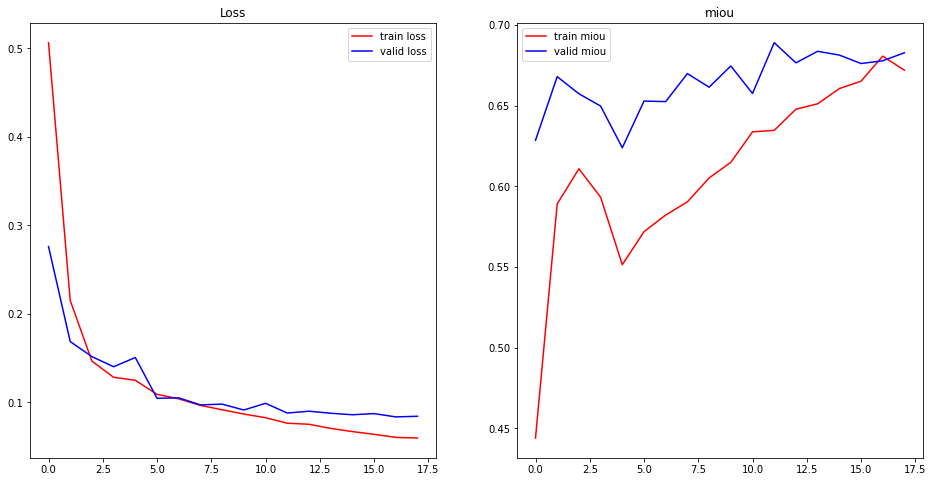

Start Train Epoch 18
Iter: 10/100, train epcoh loss: 0.060699, miou: 0.701637, iou_back : 0.980518, iou_scratch : 0.422755, time: 3.786115
Iter: 20/100, train epcoh loss: 0.059032, miou: 0.701320, iou_back : 0.981238, iou_scratch : 0.421403, time: 3.666081
Iter: 30/100, train epcoh loss: 0.058681, miou: 0.696761, iou_back : 0.981248, iou_scratch : 0.412274, time: 3.759403
Iter: 40/100, train epcoh loss: 0.059266, miou: 0.694850, iou_back : 0.980556, iou_scratch : 0.409144, time: 3.681396
Iter: 50/100, train epcoh loss: 0.060130, miou: 0.701327, iou_back : 0.980122, iou_scratch : 0.422533, time: 3.599259
Iter: 60/100, train epcoh loss: 0.059173, miou: 0.693534, iou_back : 0.980802, iou_scratch : 0.406267, time: 3.571349
Iter: 70/100, train epcoh loss: 0.058479, miou: 0.691528, iou_back : 0.980984, iou_scratch : 0.402072, time: 3.571430
Iter: 80/100, train epcoh loss: 0.057881, miou: 0.686989, iou_back : 0.981433, iou_scratch : 0.392545, time: 3.622537
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

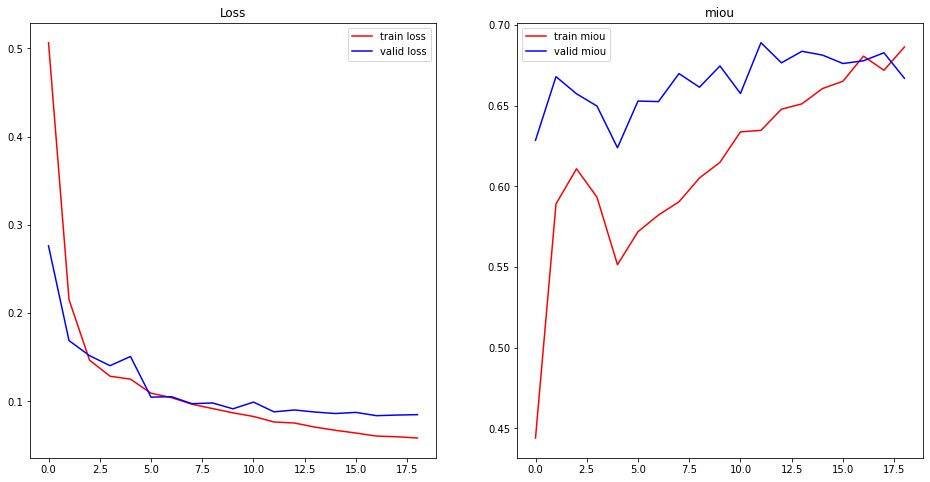

Start Train Epoch 19
Iter: 10/100, train epcoh loss: 0.054379, miou: 0.699600, iou_back : 0.982058, iou_scratch : 0.417141, time: 3.688046
Iter: 20/100, train epcoh loss: 0.052888, miou: 0.697995, iou_back : 0.983352, iou_scratch : 0.412637, time: 3.602580
Iter: 30/100, train epcoh loss: 0.055066, miou: 0.707567, iou_back : 0.981976, iou_scratch : 0.433157, time: 3.819350
Iter: 40/100, train epcoh loss: 0.053430, miou: 0.717612, iou_back : 0.982886, iou_scratch : 0.452337, time: 3.719110
Iter: 50/100, train epcoh loss: 0.055041, miou: 0.711960, iou_back : 0.982266, iou_scratch : 0.441655, time: 3.598330
Iter: 60/100, train epcoh loss: 0.053453, miou: 0.706258, iou_back : 0.982942, iou_scratch : 0.429574, time: 3.615175
Iter: 70/100, train epcoh loss: 0.054355, miou: 0.698385, iou_back : 0.982417, iou_scratch : 0.414353, time: 3.556717
Iter: 80/100, train epcoh loss: 0.053913, miou: 0.694103, iou_back : 0.982662, iou_scratch : 0.405544, time: 3.532575
Iter: 90/100, train epcoh loss: 0.0

<Figure size 432x288 with 0 Axes>

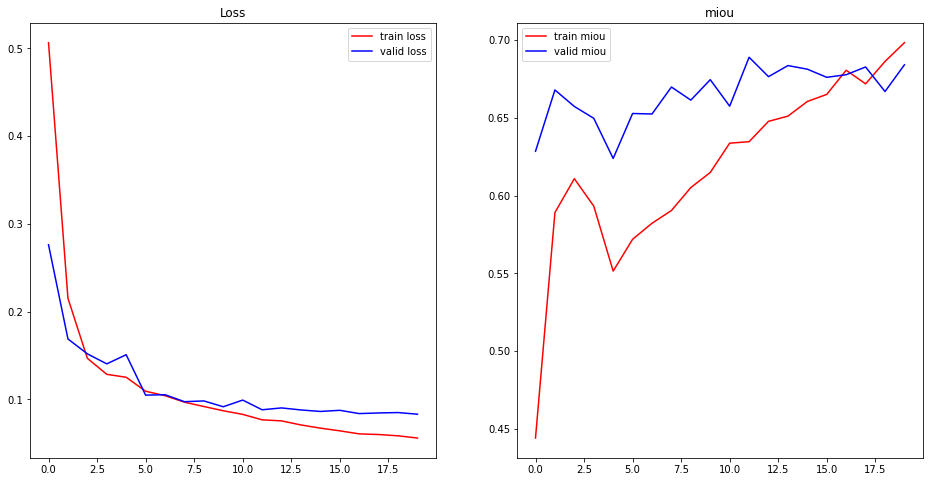

Training time : 1543.025169


<Figure size 432x288 with 0 Axes>

In [ ]:
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=20, disp_epochs=1, visualize=True)
print(f"Training time : {time.time()-start_time:>3f}")

### Fine-tuning 결과 테스트
학습된 모델 parameter 를 load 하여 test 성능을 확인해보고 test set 에서 좋은 예시를 찾아서 visualize 해봅시다.

In [ ]:
model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model", "logs")

In [ ]:
load_model = torch.load('/content/drive/MyDrive/Colab Notebooks/model/2deeplabv3.pth')
load_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model/logs/log_epoch_16.pth'))
load_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
device = "cuda"
trainer = Semantic_Seg_Trainer(model=load_model, device=device).to(device)

start_time = time.time()
trainer.test(test_loader)
print(f"Training time : {time.time()-start_time:>3f}")

===== Test Start =====
Iter: 10/133, test epcoh loss: 0.014770, miou: 0.924870, iou_back : 0.999741, iou_scratch : 0.850000, time: 14.331499
Iter: 20/133, test epcoh loss: 0.018935, miou: 0.836387, iou_back : 0.997774, iou_scratch : 0.675000, time: 13.056399
Iter: 30/133, test epcoh loss: 0.018576, miou: 0.832531, iou_back : 0.998396, iou_scratch : 0.666667, time: 12.987211
Iter: 40/133, test epcoh loss: 0.035874, miou: 0.796628, iou_back : 0.990856, iou_scratch : 0.602401, time: 15.323781
Iter: 50/133, test epcoh loss: 0.040022, miou: 0.771833, iou_back : 0.989425, iou_scratch : 0.554241, time: 13.690238
Iter: 60/133, test epcoh loss: 0.060683, miou: 0.730593, iou_back : 0.982604, iou_scratch : 0.478583, time: 13.462515
Iter: 70/133, test epcoh loss: 0.065603, miou: 0.713881, iou_back : 0.980477, iou_scratch : 0.447285, time: 14.891289
Iter: 80/133, test epcoh loss: 0.072045, miou: 0.692513, iou_back : 0.978175, iou_scratch : 0.406851, time: 13.773657
Iter: 90/133, test epcoh loss: 0.

In [ ]:
test_path = '/content/drive/MyDrive/Colab Notebooks/alpaco/Team_1. CODEnter [ Save Form : Name_FileName_Date ]/1. MAIN/Reference_file/scratch_small/test/'

In [ ]:
test_list = os.listdir(test_path + 'images')

In [ ]:
img_path = test_path + 'images/' + test_list[200]
mask_path = test_path + 'masks/' + test_list[200]

In [ ]:
image = Image.open(img_path)
# mask = Image.open(os.path.join(root,'좋은 example'))


infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image).to(device)

output = load_model(input_image.unsqueeze(dim=0))
output['out'][0].shape

torch.Size([2, 1024, 768])

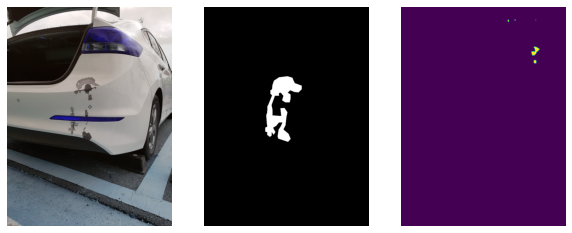

In [ ]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

cls = torch.argmax(output['out'][0].to("cpu"), dim=0).numpy()
out = np.zeros_like(cls)
out[cls==1] = 1

fig = plt.figure(figsize=(10, 10))

rows = 1
cols = 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img)
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(mask)
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(out)
ax3.axis("off")
 
plt.show()
